# **PHASE - 1: Data Loading**

In [ ]:
import numpy as np
import pandas as pd

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Load the CSV File
csv_path = "/content/drive/MyDrive/Colab Notebooks/ML_Project/Output.csv"
df = pd.read_csv(csv_path, header=None)

# Separate Features and Labels
# The last column contains labels
labels = df.iloc[:, -1].values.astype(int)
features = df.iloc[:, :-1].values

# Reshape Features into 82x82 Matrices
num_subjects = features.shape[0]
dwi_matrices = features.reshape((num_subjects, 82, 82))

# Checking Final Shapes
print("✅ Loaded DWI data successfully.")
print("🔹 Shape of dwi_matrices:", dwi_matrices.shape)  # (787, 82, 82)
print("🔹 Shape of labels:", labels.shape)                # (787,)


Mounted at /content/drive
✅ Loaded DWI data successfully.
🔹 Shape of dwi_matrices: (787, 82, 82)
🔹 Shape of labels: (787,)


# **PHASE - 2: Normalization & EDA**

**Normalization**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Normalizing the DWI Matrices
# Flattening the dwi_matrices for standardization (each feature needs to be normalized)
num_subjects = dwi_matrices.shape[0]
dwi_matrices_flat = dwi_matrices.reshape(num_subjects, -1)

# standardize the data (zero mean, unit variance)
scaler = StandardScaler()
dwi_matrices_norm = scaler.fit_transform(dwi_matrices_flat)

# Reshaping back to original (787, 82, 82) format after normalization
dwi_matrices_norm = dwi_matrices_norm.reshape(num_subjects, 82, 82)

**Exploratory Data Analysis (EDA)**

Label distribution: 0    436
1    351
Name: count, dtype: int64

Basic statistics of flattened DWI matrices:
        0           1           2           3           4           5     \
count  787.0  787.000000  787.000000  787.000000  787.000000  787.000000   
mean     0.0    0.000214    0.043581    0.001911    0.000174    0.006046   
std      0.0    0.001032    0.047689    0.002537    0.000405    0.005024   
min      0.0    0.000000    0.000102    0.000000    0.000000    0.000241   
25%      0.0    0.000000    0.012132    0.000424    0.000000    0.002749   
50%      0.0    0.000000    0.029253    0.001103    0.000000    0.004699   
75%      0.0    0.000177    0.059492    0.002376    0.000186    0.007781   
max      0.0    0.022016    0.324393    0.023456    0.003328    0.039908   

             6           7           8           9     ...        6714  \
count  787.000000  787.000000  787.000000  787.000000  ...  787.000000   
mean     0.817178    0.120969    0.011091    0.013650  ...

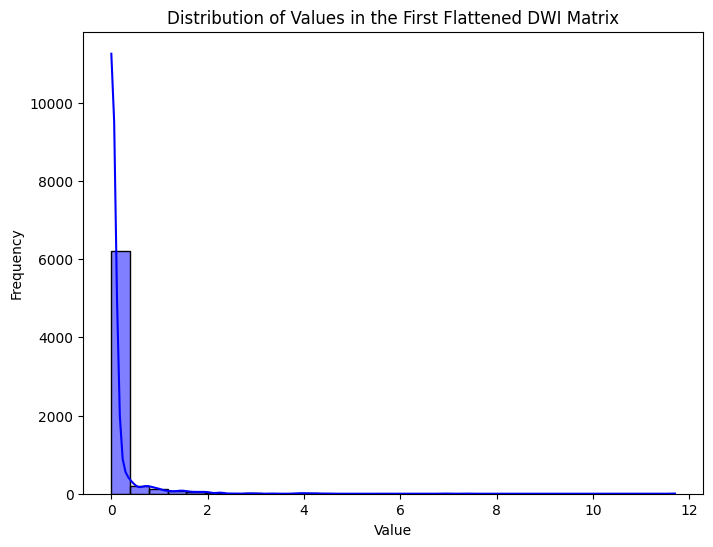

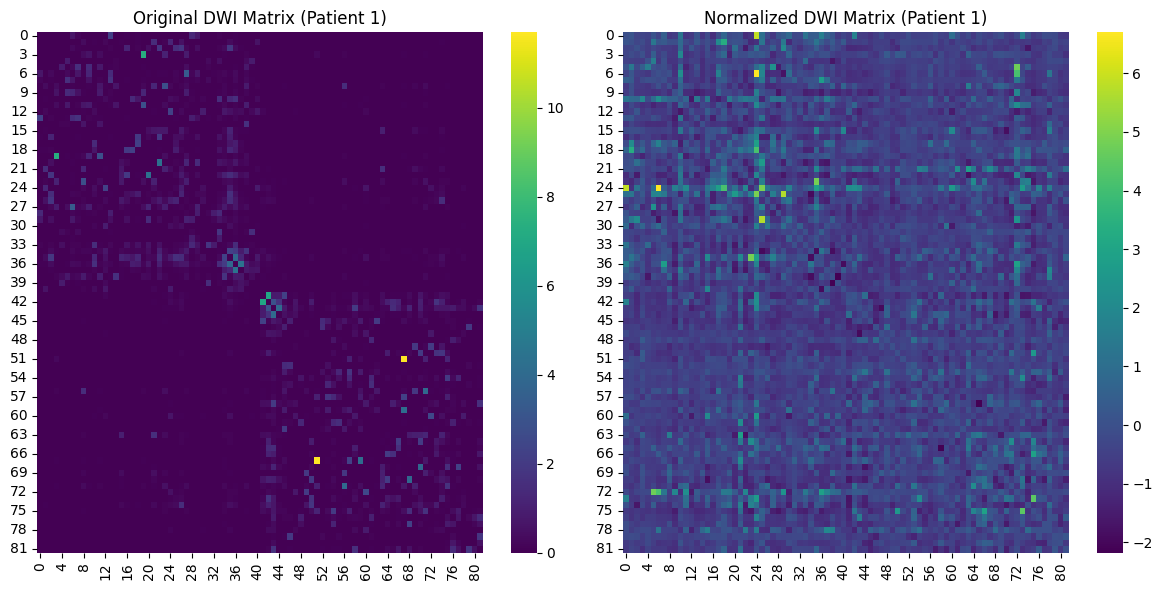

<ipython-input-5-47dc92605329>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=labels, palette='Set2')


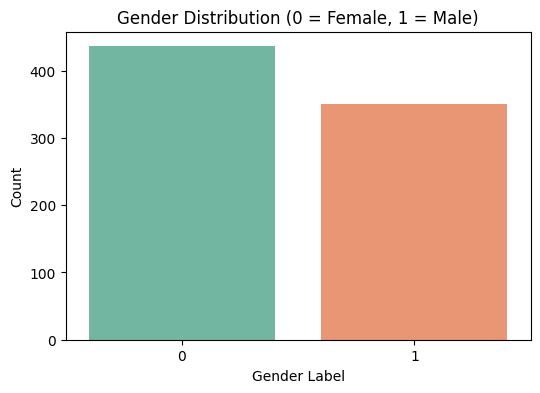

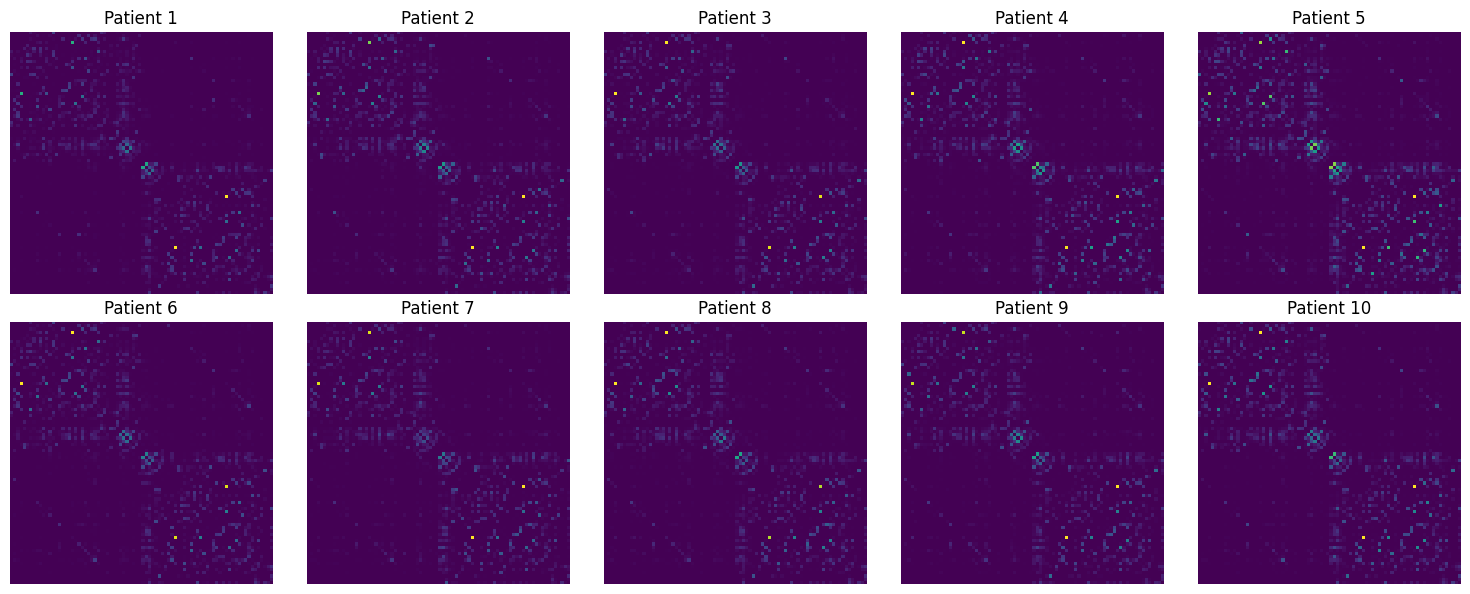

In [ ]:
# Basic Statistics of Labels and Features
print("Label distribution:", pd.Series(labels).value_counts())
print("\nBasic statistics of flattened DWI matrices:")
print(pd.DataFrame(dwi_matrices_flat).describe())  # Descriptive statistics for the flattened matrices

# Visualizing the distribution of the first flattened DWI matrix
plt.figure(figsize=(8, 6))
sns.histplot(dwi_matrices_flat[0], kde=True, color='blue', bins=30)
plt.title('Distribution of Values in the First Flattened DWI Matrix')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

# Visualizing the first DWI matrix as a heatmap (before and after normalization)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Original matrix
sns.heatmap(dwi_matrices[0], ax=ax[0], cmap='viridis', cbar=True)
ax[0].set_title("Original DWI Matrix (Patient 1)")

# Normalized matrix
sns.heatmap(dwi_matrices_norm[0], ax=ax[1], cmap='viridis', cbar=True)
ax[1].set_title("Normalized DWI Matrix (Patient 1)")

plt.tight_layout()
plt.show()

# Visualizing label distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=labels, palette='Set2')
plt.title('Gender Distribution (0 = Female, 1 = Male)')
plt.xlabel('Gender Label')
plt.ylabel('Count')
plt.show()

# Plotting the first 10 DWI matrices
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(dwi_matrices[i], cmap='viridis')
    ax.set_title(f"Patient {i+1}")
    ax.axis('off')
plt.tight_layout()
plt.show()

# **Phase - 3: Classification Pipeline – Tangent Space Embedding + Model Testing**

**Tangent Space Embedding and Basic SVM Classifier**

In [ ]:
!pip install -q pyriemann

import numpy as np
from pyriemann.tangentspace import TangentSpace
from pyriemann.estimation import Covariances
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# 1. Computing covariance matrices
cov_matrices = Covariances().fit_transform(dwi_matrices)

# 2. Regularizing for positive definiteness
epsilon = 1e-6
cov_matrices_reg = cov_matrices + np.eye(cov_matrices.shape[-1]) * epsilon

# 3. Tangent space embedding
tangent_embedder = TangentSpace(metric='riemann')
tangent_features = tangent_embedder.fit_transform(cov_matrices_reg)

print("Covariance shape:", cov_matrices_reg.shape)
print("Tangent shape:", tangent_features.shape)

# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    tangent_features, labels, test_size=0.2, random_state=42
)

# 5. Basic classifier
clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)

# 6. Predict and evaluate
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("✅ Classification Accuracy:", accuracy)


Covariance shape: (787, 82, 82)
Tangent shape: (787, 3403)
✅ Classification Accuracy: 0.8670886075949367


**Intermediate Step 1: Storing the tangent features and labels in a pickle file**

In [ ]:
import pickle

with open('/content/drive/MyDrive/Colab Notebooks/ML_Project/tangent_features.pkl', 'wb') as file:
    pickle.dump(tangent_features, file)

with open('/content/drive/MyDrive/Colab Notebooks/ML_Project/labels.pkl', 'wb') as file:
    pickle.dump(labels, file)

**Intermediate Step 2: Loading the tangent features and labels from the pickle file**

In [ ]:
import pickle

from google.colab import drive
drive.mount('/content/drive')

with open('/content/drive/MyDrive/Colab Notebooks/ML_Project/tangent_features.pkl', 'rb') as file:
    tangent_features = pickle.load(file)

with open('/content/drive/MyDrive/Colab Notebooks/ML_Project/labels.pkl', 'rb') as file:
    labels = pickle.load(file)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Model Testing with Different Feature Selection Techniques**

In [ ]:
!pip install -q xgboost lightgbm

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

# Classifiers
models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'SVM': SVC(kernel='linear', probability=True, random_state=42)
}

# Feature selection techniques
feature_selectors = {
    'SelectKBest': SelectKBest(f_classif, k=500),
    'RFE': RFE(estimator=LogisticRegression(penalty='l2', solver='liblinear'), n_features_to_select=500),
    'L1-based': LogisticRegression(penalty='l1', solver='liblinear', C=0.1, random_state=42)
}

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Storing results
results = {}

for fs_name, fs in feature_selectors.items():
    for model_name, model in models.items():
        print(f"🔍 Evaluating: {fs_name} + {model_name}")
        if fs_name == 'L1-based':
            # L1 feature selection inside logistic regression
            fs.fit(tangent_features, labels)
            mask = fs.coef_[0] != 0
            X_selected = tangent_features[:, mask]
        else:
            X_selected = fs.fit_transform(tangent_features, labels)

        scores = cross_val_score(model, X_selected, labels, cv=cv, scoring='accuracy')
        results[f"{fs_name} + {model_name}"] = scores.mean()
        print(f"✅ Mean Accuracy: {scores.mean():.4f}\n")

🔍 Evaluating: SelectKBest + RandomForest
✅ Mean Accuracy: 0.8475

🔍 Evaluating: SelectKBest + XGBoost
✅ Mean Accuracy: 0.8107

🔍 Evaluating: SelectKBest + LightGBM
[LightGBM] [Info] Number of positive: 280, number of negative: 349
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 105000
[LightGBM] [Info] Number of data points in the train set: 629, number of used features: 500
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.445151 -> initscore=-0.220282
[LightGBM] [Info] Start training from score -0.220282
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

# **Testing RFE + SVM for Overfitting**

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif, RFE

# Refit RFE on full training set
rfe = RFE(estimator=LogisticRegression(penalty='l2', solver='liblinear'), n_features_to_select=500)
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_test_rfe = rfe.transform(X_test)

# Train SVM
from sklearn.svm import SVC
svm = SVC()
svm.fit(X_train_rfe, y_train)

# Accuracy on both
train_acc = svm.score(X_train_rfe, y_train)
test_acc = svm.score(X_test_rfe, y_test)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Train Accuracy: 1.0000
Test Accuracy: 0.8608


**Hyperparameter Tuning with Optuna for the Second Best Combo (L1-based + SVM)**

In [ ]:
!pip install -q optuna

import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
import numpy as np
from sklearn.model_selection import train_test_split

# Loading tangent features and labels
# tangent_features = np.load('/content/drive/MyDrive/Colab Notebooks/ML_Project/tangent_features.pkl', allow_pickle=True)
# labels = np.load('/content/drive/MyDrive/Colab Notebooks/ML_Project/labels.pkl', allow_pickle=True)

# Split the tangent features
X_train, X_test, y_train, y_test = train_test_split(
    tangent_features, labels, test_size=0.2, stratify=labels, random_state=42
)

def objective(trial):
    # Step 1: L1-Based Feature Selection
    c_l1 = trial.suggest_float('c_l1', 1e-4, 1e2, log=True)
    l1_model = LogisticRegression(
        penalty='l1',
        solver='saga',
        C=c_l1,
        max_iter=5000,
        random_state=42
    )
    l1_model.fit(X_train, y_train)

    selector = SelectFromModel(l1_model, prefit=True)
    X_train_sel = selector.transform(X_train)
    X_test_sel = selector.transform(X_test)

    if X_train_sel.shape[1] == 0:
        return 0.0

    # Step 2: SVM Classification
    c_svm = trial.suggest_float('c_svm', 1e-3, 1e1, log=True)
    svm = SVC(kernel='linear', C=c_svm, random_state=42)
    svm.fit(X_train_sel, y_train)
    y_pred = svm.predict(X_test_sel)

    # Calculating performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')

    y_prob = svm.decision_function(X_test_sel)  # Get decision function values
    auc = roc_auc_score(y_test, y_prob)

    # Log metrics to Optuna
    trial.set_user_attr('accuracy', accuracy)
    trial.set_user_attr('f1_macro', f1)
    trial.set_user_attr('precision_macro', precision)
    trial.set_user_attr('recall_macro', recall)
    trial.set_user_attr('auc', auc)

    return accuracy  # Optimize for accuracy primarily

# Create and optimize the study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, n_jobs=-1)

print("✅ Best Accuracy:", study.best_value)
print("✅ Best Hyperparameters:", study.best_params)

# Accessing logged metrics
best_trial = study.best_trial
accuracy = best_trial.user_attrs['accuracy']
f1_macro = best_trial.user_attrs['f1_macro']
precision_macro = best_trial.user_attrs['precision_macro']
recall_macro = best_trial.user_attrs['recall_macro']
auc = best_trial.user_attrs['auc']

print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score (Macro): {f1_macro:.4f}")
print(f"Precision (Macro): {precision_macro:.4f}")
print(f"Recall (Macro): {recall_macro:.4f}")
print(f"AUC: {auc:.4f}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 15.1 MB/s eta 0:00:00


[I 2025-05-04 17:33:05,859] A new study created in memory with name: no-name-71f00e15-28b9-44c0-bcc9-91e97085a7a0
[I 2025-05-04 17:33:34,602] Trial 1 finished with value: 0.8164556962025317 and parameters: {'c_l1': 0.1854475324829749, 'c_svm': 0.5016056768831499}. Best is trial 1 with value: 0.8164556962025317.
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_base.py:122: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_base.py:122: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
[I 2025-05-04 17:33:35,076] Trial 2 finished with value: 0.0 and parameters: {'c_l1': 0.0024669307266477333}. Best is trial 1 with value: 0.8164556962025317.
[I 2025-05-04 17:33:50,979] Trial 3 finished with value: 0.8037974683544303 and parameters: {'c_l1': 0.043680861942086154, 'c_svm

✅ Best Accuracy: 0.8670886075949367
✅ Best Hyperparameters: {'c_l1': 98.63613120784582, 'c_svm': 0.004910806130093409}
Accuracy: 0.8671
F1-Score (Macro): 0.8647
Precision (Macro): 0.8669
Recall (Macro): 0.8631
AUC: 0.9310


# **Phase 4: Dimensionality Reduction & Visualization**

🔹 Selected features shape: (787, 1189)


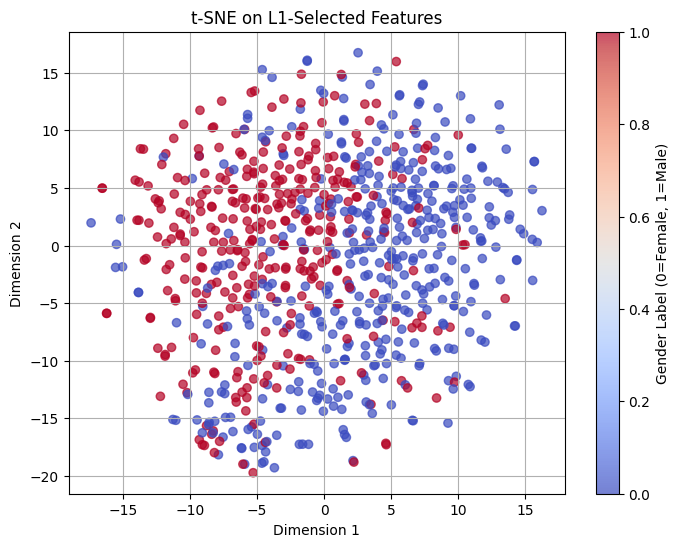

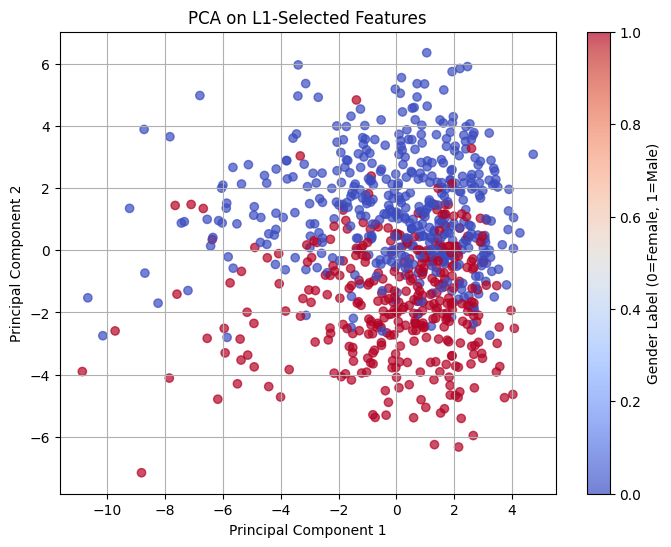

✅ Embeddings and labels saved.


In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
import numpy as np

# Use the best c_l1 from the Optuna study (set a default (1.0) if not available)
best_c_l1 = study.best_params.get('c_l1', 1.0)

# Refit the L1-based Logistic Regression using the best hyperparameter on full tangent features
l1_model = LogisticRegression(penalty='l1', solver='saga', C=best_c_l1, max_iter=5000, random_state=42)
l1_model.fit(tangent_features, labels)

# Feature selection via L1-based model
selector = SelectFromModel(l1_model, prefit=True)
X_selected = selector.transform(tangent_features)

print("🔹 Selected features shape:", X_selected.shape)

# t-SNE Visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_2d_tsne = tsne.fit_transform(X_selected)

plt.figure(figsize=(8, 6))
plt.scatter(X_2d_tsne[:, 0], X_2d_tsne[:, 1], c=labels, cmap='coolwarm', alpha=0.7)
plt.colorbar(label='Gender Label (0=Female, 1=Male)')
plt.title("t-SNE on L1-Selected Features")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()

# PCA Visualization
pca = PCA(n_components=2)
X_2d_pca = pca.fit_transform(X_selected)

plt.figure(figsize=(8, 6))
plt.scatter(X_2d_pca[:, 0], X_2d_pca[:, 1], c=labels, cmap='coolwarm', alpha=0.7)
plt.colorbar(label='Gender Label (0=Female, 1=Male)')
plt.title("PCA on L1-Selected Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

# Saving the Embeddings and Labels
np.save("/content/drive/MyDrive/Colab Notebooks/ML_Project/selected_l1_features_embeddings.npy", X_selected)
np.save("/content/drive/MyDrive/Colab Notebooks/ML_Project/dwi-labels.npy", labels)
print("✅ Embeddings and labels saved.")


# **Fusing DWI & fMRI features**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using 'labels' variable from previous cell.
Fused feature matrix shape: (787, 2891)


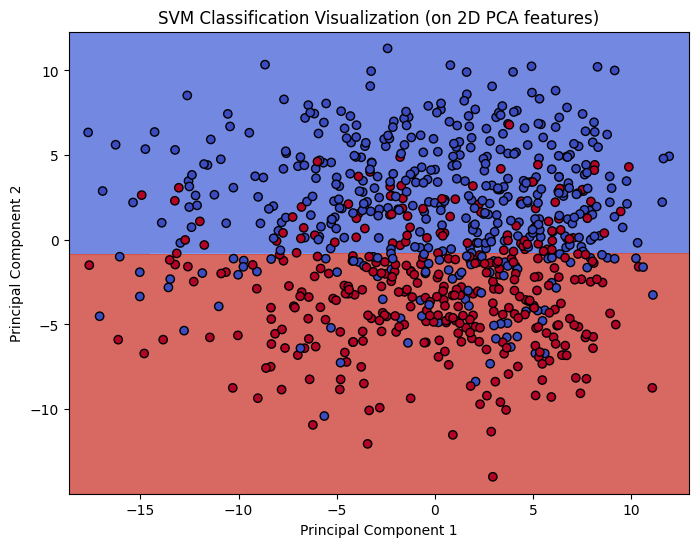


--- Evaluating SVM on Original Fused Features ---
Accuracy on fused features: 0.9304
Precision (Macro) on fused features: 0.9317
Recall (Macro) on fused features: 0.9273
F1 Score (Macro) on fused features: 0.9291
AUC on fused features: 0.9750


In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pickle

from google.colab import drive
drive.mount('/content/drive')

# to avoid errors from runtime disconnection
try:
    # Check if 'labels' variable exists from previous cells
    _ = labels
    print("Using 'labels' variable from previous cell.")
except NameError:
    print("Loading 'labels' from pickle file.")
    with open('/content/drive/MyDrive/Colab Notebooks/ML_Project/labels.pkl', 'rb') as file:
        labels = pickle.load(file)


# 1. Load the Features and Labels
X_fmri = np.load('/content/drive/MyDrive/Colab Notebooks/ML_Project/selected_tangent_embeddings.npy')
X_dwi = np.load('/content/drive/MyDrive/Colab Notebooks/ML_Project/selected_l1_features_embeddings.npy')

# 2. Feature Scaling
scaler_fmri = StandardScaler()
scaler_dwi = StandardScaler()
X_fmri_scaled = scaler_fmri.fit_transform(X_fmri)
X_dwi_scaled = scaler_dwi.fit_transform(X_dwi)

# 3. Feature Fusion
X_fused = np.hstack([X_fmri_scaled, X_dwi_scaled])
print("Fused feature matrix shape:", X_fused.shape)

# 4. Dimensionality Reduction for Visualization
pca = PCA(n_components=2)  # Reduce to 2 dimensions
X_fused_2d = pca.fit_transform(X_fused)

# 5. Train/Test Split in 2D (for visualization only)
X_train_2d_viz, X_test_2d_viz, y_train_viz, y_test_viz = train_test_split(
    X_fused_2d, labels, test_size=0.2, random_state=42, stratify=labels
)

# 6. Train SVM in 2D (for visualization only)
clf_viz = SVC(kernel='linear', random_state=42)
clf_viz.fit(X_train_2d_viz, y_train_viz)

# 7. Visualization
# Creating a meshgrid to plot the decision boundary
x_min, x_max = X_fused_2d[:, 0].min() - 1, X_fused_2d[:, 0].max() + 1
y_min, y_max = X_fused_2d[:, 1].min() - 1, X_fused_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

# Predict class labels for the meshgrid points
Z = clf_viz.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary and data points
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.8)
plt.scatter(X_fused_2d[:, 0], X_fused_2d[:, 1], c=labels, cmap='coolwarm', edgecolors='k')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('SVM Classification Visualization (on 2D PCA features)')
plt.show()

# 8. Classification and Evaluation (using original fused features)
# Using the full fused dataset for the actual evaluation split
X_train, X_test, y_train, y_test = train_test_split(
    X_fused, labels, test_size=0.2, random_state=42, stratify=labels
)

print("\n--- Evaluating SVM on Original Fused Features ---")
clf = SVC(kernel='linear', random_state=42)  # Using the original fused features
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
# Get decision function scores for AUC calculation
y_scores = clf.decision_function(X_test)

# Calculating metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
auc = roc_auc_score(y_test, y_scores)

print(f"Accuracy on fused features: {accuracy:.4f}")
print(f"Precision (Macro) on fused features: {precision:.4f}")
print(f"Recall (Macro) on fused features: {recall:.4f}")
print(f"F1 Score (Macro) on fused features: {f1:.4f}")
print(f"AUC on fused features: {auc:.4f}")

**tSNE for fused features**

Mounted at /content/drive


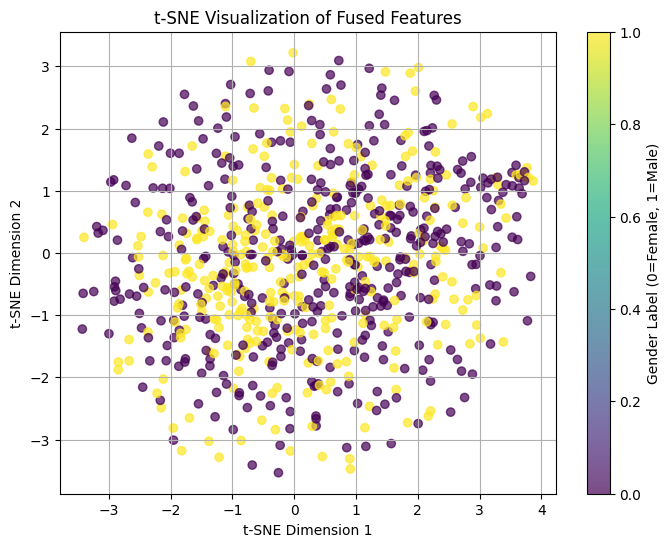

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

# 1. Load the Features and Labels
X_fmri = np.load('/content/drive/MyDrive/Colab Notebooks/ML_Project/selected_tangent_embeddings.npy')
X_dwi = np.load('/content/drive/MyDrive/Colab Notebooks/ML_Project/selected_l1_features_embeddings.npy')
labels = np.load('/content/drive/MyDrive/Colab Notebooks/ML_Project/dwi-labels.npy')

# 2. Feature Scaling
scaler_fmri = StandardScaler()
scaler_dwi = StandardScaler()
X_fmri_scaled = scaler_fmri.fit_transform(X_fmri)
X_dwi_scaled = scaler_dwi.fit_transform(X_dwi)

# 3. Feature Fusion
X_fused = np.hstack([X_fmri_scaled, X_dwi_scaled])

# 4. Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_fused_tsne = tsne.fit_transform(X_fused)

# 5. Visualization
plt.figure(figsize=(8, 6))
plt.scatter(X_fused_tsne[:, 0], X_fused_tsne[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.colorbar(label='Gender Label (0=Female, 1=Male)')
plt.title('t-SNE Visualization of Fused Features')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True)
plt.show()